# Mode fitting

Here we will make a simple hierarchical model that encodes some knowledge of quasi-equally spaced modes of oscillation into the prior.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

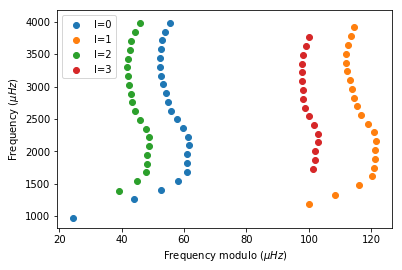

In [5]:
dnu_sol = 136e-6  # book value of large freq separation for the sun

df = pd.read_table('broomhall2009.txt', delim_whitespace=True, names=('n', 'l', 'nu', 'nu_unc'))  #import data

lmodes = []
dnu_avg = []
f_mod = []

for i in range(4):
    lmodes.append(df[df.l == i])
    dnu_avg.append(np.median(np.diff(lmodes[i].nu)))
    f_mod.append(lmodes[i].nu % dnu_avg[i])
    label = "l="+str(i)
    plt.scatter(f_mod[i], lmodes[i].nu, label = label)
    
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

The lower departure from a straight line is due to the BCZ, so the lower frequencies are not useful in analysing the response from the HeII ionization zone. Frequencies below 1700 $\mu$Hz are omitted.

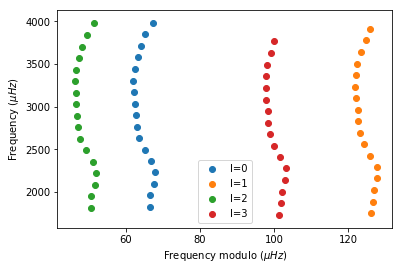

In [153]:
for i in range(4):
    lmodes[i] = lmodes[i].loc[lmodes[i].nu > 1700]
    lmodes[i] = lmodes[i].set_index(np.arange(0,len(lmodes[i]),1))

dnu_avg = []
f_mod = []
for i in range(4):
    dnu_avg.append(np.median(np.diff(lmodes[i].nu)))
    f_mod.append(lmodes[i].nu % dnu_avg[i])
    label = "l="+str(i)
    plt.scatter(f_mod[i], lmodes[i].nu, label = label)
    
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

To find a ballpark figure before defining priors, I will apply the model from Vrard:

$\nu_{UP}(n,0)=\big(n+\epsilon+\frac{\alpha}{2}(n-n_{max})^2\big)\langle\Delta\nu\rangle$

In [243]:
def model(n, dnu, numax, epsilon, alpha):
    nmax = numax/dnu + epsilon
    freqs = (n + epsilon + (alpha/2)*(n-nmax)**2)*dnu #Vrard universal pattern
    return freqs

In [339]:
alpha = 0.015*dnu_avg[0]**(-0.32) #from vrard paper
print(alpha)
f = model(lmodes[0].n, dnu_avg[0], 2900, 1.437, alpha)

0.003121182039454458


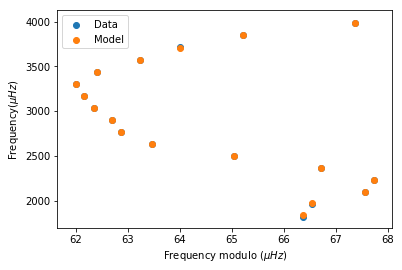

In [340]:
plt.scatter(f_mod[0], lmodes[0].nu, label = 'Data')
plt.scatter(f_mod[0], f, label = 'Model')
plt.ylabel(r'Frequency($\mu Hz$)')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.legend()
#plt.xlim(0, 135.2)

The Vrard universal pattern describes this data very well when using parameters: $\epsilon$ = 1.437, $\alpha$ = 0.0031212, and $\nu_{max}$ = 2900. Now apply stan model to try and improve these.

In [347]:
code = '''
functions {
    real model(real n, real dnu, real numax, real epsilon, real alpha){
        real nmax = numax/dnu + epsilon;
        real freqs = (n + epsilon + (alpha/2)*(n-nmax)^2)*dnu;
        return freqs;
    }
}
data {
    int N; // Data points
    real n[N];
    real dnu;
    real fobs[N];
}
parameters {
    real epsilon;
    real<lower=0, upper=0.2> alpha;
    real numax;
}
model {
    vector[N] mod;
    epsilon ~ normal(1.437, 0.05);
    alpha ~ normal(0.00312, 0.0005);
    numax ~ normal(2900, 100);
    for (i in 1:N) mod[i] = model(n[N], dnu, numax, epsilon, alpha);
    mod ~ normal(fobs, 50);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_801151a939ae5dad2d92e303a50a0551 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpndp8boi1/stanfit4anon_model_801151a939ae5dad2d92e303a50a0551_2365023474917419397.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [348]:
stan_data = {'N': len(lmodes[0]), 'n': lmodes[0].n,
             'fobs': lmodes[0].nu, 'dnu': dnu_avg[0]
            }
nchains = 4
#start = {'A': 3, 'G': 4, 'phi': 1}
fitsm = sm.sampling(data=stan_data, iter=10000, chains=nchains) #init=[start for n in range(nchains)])

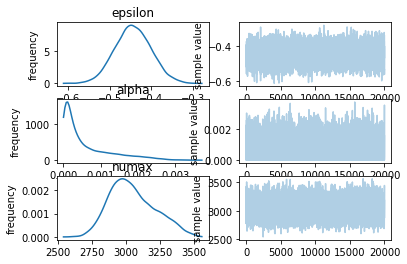

In [349]:
fitsm.plot()
plt.show()

In [350]:
print(fitsm)

Inference for Stan model: anon_model_801151a939ae5dad2d92e303a50a0551.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
epsilon  -0.44  5.3e-4   0.04  -0.53  -0.47  -0.44  -0.41  -0.36   6869    1.0
alpha   5.8e-4  1.4e-5 6.7e-4 6.6e-6 9.5e-5 2.9e-4 8.6e-4 2.4e-3   2304    1.0
numax   3050.0    3.35 167.54 2770.0 2926.1 3027.7 3161.8 3402.6   2504    1.0
lp__     -4513    0.02   1.26  -4516  -4514  -4513  -4512  -4512   5619    1.0

Samples were drawn using NUTS at Thu Nov 29 15:21:22 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


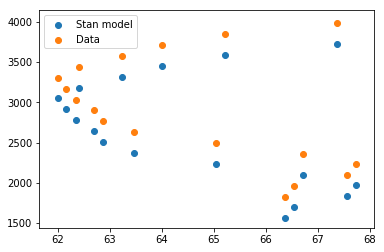

In [351]:
stanfit = model(lmodes[0].n, dnu_avg[0], fitsm['numax'].mean(), fitsm['epsilon'].mean(), fitsm['alpha'].mean())

plt.subplots()
plt.scatter(f_mod[0], stanfit, label = 'Stan model')
plt.scatter(f_mod[0], lmodes[0].nu, label = 'Data')
plt.legend()

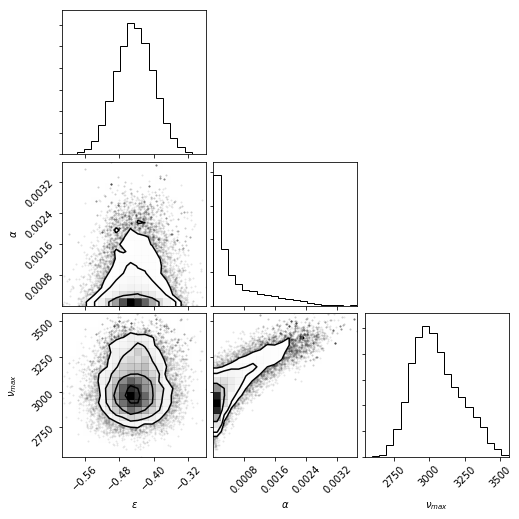

In [352]:
import corner
data = np.vstack([fitsm['epsilon'], fitsm['alpha'], fitsm['numax']]).T
corner.corner(data, labels=[r'$\epsilon$', r'$\alpha$', r'$\nu_{max}$'])
plt.show()

This analysis will use the methods detailed in Vrard 2015 and, as such, will use its definitions.

The definition for the local frequency spacing is:

$\Delta\nu(n) = \frac{\nu_{n+1,0}-\nu_{n-1,0}}{2}$.

At the edges of the measured radial modes, we cannot use this equation and replace it by the frequency difference between two consecutive radial modes.

In [157]:
lmodes[0]['dnu_n'] = (lmodes[0]['nu'].diff(2).shift(-1)/2)
lmodes[0]['dnu_n'][0] = lmodes[0]['nu'].diff(1)[1]
lmodes[0]['dnu_n'][16] = (lmodes[0]['nu'].diff(1)[16])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We assume the frequency with largest amplitude is at $n=22$ meaning $\nu_{max} = 3168.618$. This is then used in the determination of the universal pattern to which the frequency separation will be compared:

$\Delta\nu_{UP}(n)=(1+\alpha(n-n_{max}))\langle\Delta\nu\rangle$

We compute the difference between the observed local large separation and the theoretical local large separation predicted by the universal pattern:

$\delta_{g,obs}=\Delta\nu(n)-\Delta\nu_{UP}(n)$

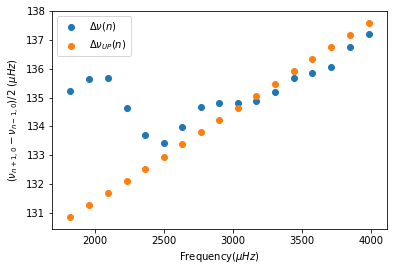

In [227]:
nmax = 22
numax = 3168.618
alpha = 0.015*dnu_avg[0]**(-0.32)
dnu_UP = (1+alpha*(lmodes[0].n-nmax))*dnu_avg[0]

plt.scatter(lmodes[0].nu, lmodes[0].dnu_n, label = r'$\Delta\nu(n)$')
plt.xlabel(r'Frequency($\mu Hz$)')
plt.ylabel(r'$(\nu_{n+1,0}-\nu_{n-1,0})/2$ ($\mu Hz$)')
plt.scatter(lmodes[0].nu, dnu_UP, label = r'$\Delta\nu_{UP}(n)$')
plt.legend()

We now subtract the universal pattern from the data in order to remove the curvature term.

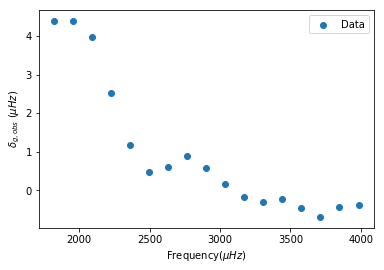

In [242]:
deltag = lmodes[0].dnu_n - dnu_UP

plt.scatter(lmodes[0].nu, deltag, label='Data')
plt.xlabel(r'Frequency($\mu Hz$)')
plt.ylabel(r'$\delta_{g,obs}$ ($\mu Hz$)')
plt.legend()

The amplitude can be found by fitting an oscillatory component to the resultant frequency variations obtained after removal of the curvature term from the measurements:

$\delta_{g,obs}=\mathcal{A}\langle\Delta\nu\rangle cos\big(\frac{2\pi(\nu-\nu_{max})}{\mathcal{G}\langle\Delta\nu\rangle}+\phi\big)$

where $\mathcal{G}$ is the period of the oscillation expressed in units of $\langle\Delta\nu\rangle$, $\mathcal{A}$ is the amplitude of the oscillation in units of $\langle\Delta\nu\rangle$ and $\phi$ is the phase of the oscillation centered on $\nu_{max}$.

In [235]:
code = '''
functions {
    real dgobs(real A, real numax, real nu, real G, real phi){
        return A * cos((2*pi()*(nu-numax))/G + phi);
    }
}
data {
    int N; // Data points
    real nu[N];
    real numax;
    real dnu_avg;
    real dg[N];
}
parameters {
    real<lower = 0> G;
    real<lower = 0> A;
    real<lower = 0> phi;
}
model {
    vector[N] mod;
    A ~ normal(4, 1.5);
    G ~ normal(7, 2);
    phi ~ normal(1.5*pi(), 1);
    for (i in 1:N) mod[i] = dgobs(A, numax, nu[N], G, phi);
    mod ~ normal(dg, 1);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a84c71713f5d490c50c75c3320d36a61 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmp9_i_sg4f/stanfit4anon_model_a84c71713f5d490c50c75c3320d36a61_4471298858285292731.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


The code takes a while to converge.  We run for 20000 iterations and check the results.

In [236]:
stan_data = {'N': len(lmodes[0]), 
             'nu': lmodes[0].nu, 'dg': deltag,
             'numax': numax, 'dnu_avg': dnu_avg[0]}
nchains = 4
start = {'A': 3, 'G': 4, 'phi': 1}
fitsm = sm.sampling(data=stan_data, iter=20000, chains=nchains, init=[start for n in range(nchains)])

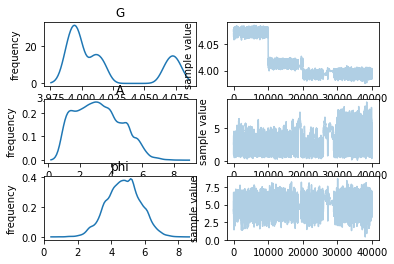

In [237]:
fitsm.plot()
plt.show()

In [238]:
print(fitsm)

Inference for Stan model: anon_model_a84c71713f5d490c50c75c3320d36a61.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
G      4.02    0.02   0.03   3.99   3.99    4.0   4.04   4.08      2   7.37
A      3.21    0.13   1.44   0.93   2.05   3.12   4.24   6.01    116   1.06
phi    4.74    0.06    1.0   2.75   4.06   4.75   5.41   6.63    266   1.02
lp__ -23.19    0.05   1.46 -26.64 -24.06 -22.83 -22.07 -21.33    905   1.01

Samples were drawn using NUTS at Thu Nov 29 14:07:22 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


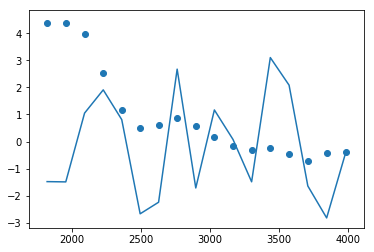

In [239]:
dgstan = fitsm['A'].mean() * np.cos((2*np.pi*(lmodes[0].nu-numax))/fitsm['G'].mean() + fitsm['phi'].mean())

plt.subplots()
plt.plot(lmodes[0].nu, dgstan, label = 'Stan model')
plt.scatter(lmodes[0].nu, deltag, label = 'Data')

Here is a corner plot of the results:

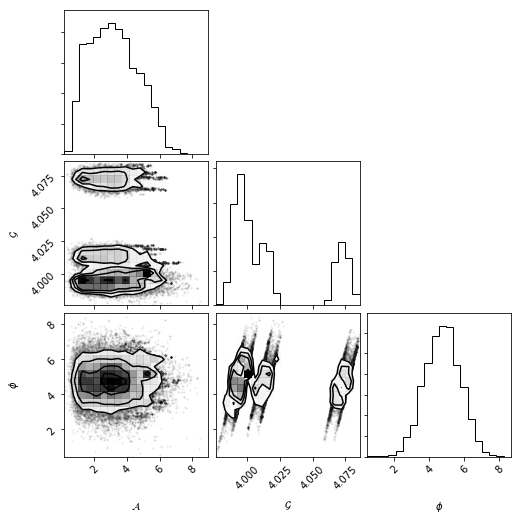

In [240]:
import corner
data = np.vstack([fitsm['A'], fitsm['G'], fitsm['phi']]).T
corner.corner(data, labels=[r'$\mathcal{A}$', r'$\mathcal{G}$', r'$\phi$'])
plt.show()

From Nature volume 215, pages 43–44 (01 July 1967) the helium mass fraction of the sun is between 0.20 and 0.27.